In [78]:
import csv
import re
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style, colors
# import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import gridspec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to enable jupyter ipython widgets run following line at command line
# jupyter nbextension enable --py widgetsnbextension
# to import ipywidgets in jupyter notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


# constants

In [2]:
# plot parameters
xoffset = 0.125 #colum step, this times the column number gives the x coordinates
yoffset = 0.8 # y coordinate where the legend starts to be plotted
titley = 0.87 # legend title y
legspace = 0.04 # space between legend pathes and the text
rowstep = 0.075 # space between rows of legends

In [112]:
amp_threshold = 2 # gistic thresholded all_gene_thresholded file
del_threshold = -2 
# use this file for final histology
# final_histologyf = '/projects/trans_scratch/validations/workspace/szong/Cervical/histologic_diagnosis_118_20190108.txt'
# clinic_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/nationwidechildrens.org_clinical_patient_cesc.txt'
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/'
patients_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt'
colormap_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
legend_cmap = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps_for_legend.txt'
# mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details.txt'
mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency_20190326.txt'
codingmut_rate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/coding_mutation_rate.txt.20190104'
# gatk_cnv = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_thresholded.by_genes.txt'
# gatk_cnv = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_data_by_genes.txt'
apobec_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/other/master_patient_table_20180813_123samples_all_from_Reanne.txt'
covariate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_covariates_final_20190325.txt'
hrd_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/nci_results.txt'

# 1. functions

In [4]:
def plot_mutation_rate(ax, df, patients, clrmap_dict):
    ax.set_title("") 
    clrs = [clrmap_dict[m] for m in ['Non-synonymous', 'Synonymous']]
    df_mut_rate = df[['nsyno_mut_rate', 'syno_mut_rate']].reindex(patients)
    df_mut_rate.plot.bar(stacked=True, ax=ax, color=clrs, width=.8)
    ax.set_ylim(0,100)
#     _ = ax.set_xticklabels(df_mut_rate.index.tolist(), fontsize=5)
#     _ = ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=19)
    _ = ax.legend(labels=['Non-synonymous', 'Synonymous'], frameon=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)
    _ = plt.legend('')
    yticklbs = [str(int(i)) for i in ax.get_yticks()]
    yticklbs[0] = ' '
    ax.set_yticklabels(yticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, pad=12, colors='black')
    ax.spines['top'].set_visible(False)
    plt.grid(axis='y', linewidth=0.5, linestyle='-', color='gray')
    ax.set_xticklabels('')
#     ax.margins(x=0.075) # 5% padding in all directions
    return df_mut_rate

In [164]:
def plot_cnv_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    yticklabels = ['']*len(df.index.tolist())
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    for c in dfcnvtmp2.columns[:-1]:
        dfcnvtmp2[c] = dfcnvtmp2[c].astype(float)
    (df.groupby('HIV_status').mean()*100).T.plot(kind='barh', ax=ax, stacked=False, width=0.8, color=hiv_colors)
    plt.gca().invert_yaxis()
    _ = ax.set_yticklabels(yticklabels, rotation=0, fontsize=19)
    adjust_spines(ax, ['top', 'right'])
    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
#     _ = ax.set_ylabel('')
#     _ = plt.setp(ax.get_yticklines(),visible=False)
#     _ = plt.setp(ax.get_yticklines(),visible=False)
    xticklbs = [str(int(i)) for i in ax.get_xticks()]
    xticklbs[0] = ' '
    xticklbs[4] = ''.join(['  ', xticklbs[4], ' %'])
    ax.set_xticklabels(xticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, colors='black')
    ax.spines['top'].set_visible(False)
    
    plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
 

In [6]:
def plot_gene_mutation_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    df = df.drop('mfreq', axis=1)
    yticklabels = ['']*len(df.index.tolist())
    yticklabels[0] = ''
    yticklabels[1] = ''
    # bar color consistent to heatmap
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    df = df[['hiv_{}_mfreq'.format(i.lower()[:3]) for i in HIV_status]]
    df.plot(kind='barh', ax=ax, stacked=False, width=.8, color=hiv_colors)  
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    # _ = ax.tick_params(axis='y', which='major', labelsize=20, pad=0) # add/reduce space between axis and its ticklables

    _ = ax.set_yticklabels(yticklabels, rotation=0, fontsize=19)
    adjust_spines(ax, ['top', 'right'])

    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
    xticklbs = [str(int(i)) for i in ax.get_xticks()]
    xticklbs[0] = ' '
    xticklbs[4] = ''.join(['% ', xticklbs[4], '  '])
    ax.set_xticklabels(xticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, colors='black')
    ax.spines['top'].set_visible(False)

    plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
    

In [7]:
# def plot_mutation_type_count(ax, df, mut_colors):
#     ax.set_title("")  
# #     df_type_count = df.drop(['HIV_status', 'Putative_histology'])
#     df_type_count = df.T.apply(lambda x: x.value_counts()).T
#     # insert 2 fake rows in the begining to line up the bars with genes
# #     df_type_count = pd.concat([pd.DataFrame([[np.nan]*6, [np.nan]*6], 
# #                                                      index=['HIV_status', 'Putative_histology'], 
# #                                                      columns=df_type_count.columns), 
# #                                                      df_type_count])
#     df_type_count = df_type_count[mutations]
#     df_type_count.plot(kind='barh',ax=ax, stacked=True, width=.8, color=mut_colors)
#     plt.gca().invert_yaxis()
#     ax.legend_.remove()
#     ax.yaxis.set_ticks_position('left')
#     adjust_spines(ax, ['top', 'right'])
#     ax.spines['right'].set_visible(False)
#     # ax.spines['top'].set_visible(False)
#     ax.set_yticklabels('')
#     ax.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=19, rotation=90)

In [206]:
def plot_cnv_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    yticklabels = df.columns.tolist()
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    for c in dfcnvtmp2.columns[:-1]:
        dfcnvtmp2[c] = dfcnvtmp2[c].astype(float)
    (df.groupby('HIV_status').mean()*100).T.plot(kind='barh', ax=ax, stacked=False, width=0.8, color=hiv_colors)
    
    plt.gca().invert_yaxis()
    adjust_spines(ax, ['top', 'right'])
    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_yticklabels(yticklabels, rotation=0,fontweight='bold',fontsize=20, horizontalalignment='left')
    _ = ax.tick_params(axis='y', which='major', pad=125, labelsize=22)
    #     _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
#     _ = plt.setp(ax.get_yticklines(),visible=False)
    xticklbs = [str(int(i)) for i in ax.get_xticks()]
    xticklbs[0] = ' '
    xticklbs[4] = ''.join(['  ', xticklbs[4], ' %'])
    ax.set_xticklabels(xticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, colors='black')
    ax.spines['top'].set_visible(False)
    
    plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
 

In [8]:
' '.join(re.split('\(|%', 'kert(4%)'))
# a='Beautiful, is; better*than\nugly'
# import re
# re.split('; |, |\*|\n',a)

'kert 4 )'

In [212]:
def plot_mutation_heatmap(ax, df, map_dict, cmap):
    df = df.apply(lambda x: x.map(map_dict)).astype(float)
    sns.heatmap(df, 
                ax=ax, 
                cmap=cmap,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) #cbar_ax=ax1,
#     _ = ax.tick_params(axis='y', which='major', labelsize=27)
#     _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    yticklbs = ['  '.join(re.split('\(|%', str(i.get_text()))[:2]) for i in ax.get_yticklabels()]
    _ = ax.set_yticklabels(yticklbs, fontweight='bold',fontsize=20, rotation=0)
    _ = ax.tick_params(axis='y', which='major', pad=12, labelsize=22)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    # _ = ax.set_yticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    # set heatmap background color, nan values will be this color
    _ = ax.set_facecolor('#f2f2f3')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)
    # set ticklabel fontname, need to add the font first, leave it out for now
#     for tick in ax.get_yticklabels():
#         tick.set_fontname("Helvetica")

    return df

In [138]:
def plot_covariate_track(ax, df, patients, map_dict_cov, cmap_cov):
    df = df[patients]
    df_mapped = df.apply(lambda x: x.map(map_dict_cov)).astype(float)
#     print(df_mapped)
    sns.heatmap(df_mapped, 
                ax=ax, 
                cmap=cmap_cov,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) 
    _ = ax.tick_params(axis='y', which='major', labelsize=19)
    yticklbs = [' '.join(i.get_text().upper().split('_')) for i in ax.yaxis.get_majorticklabels()]
    _ = ax.set_yticklabels(yticklbs, fontsize=20, rotation=0)
#     _ = ax.set_yticklabels(yticklbs, fontweight='bold',fontsize=20, rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)

    return df_mapped

In [11]:
def numeric_covariate(ax, df, patients, ax2):
    df = df[patients]
    ax = sns.heatmap(df, ax=ax, cbar=True, xticklabels=False, yticklabels=True, cbar_ax=ax2, cmap="PuBu")
    # cbar controls if cbar is drawn, cbar_ax controls which ax to draw
    _ = ax.tick_params(axis='y', which='major', labelsize=19)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
#     cax = plt.gcf().axes[1]
#     cax.tick_params(labelsize=50)
#     _ = ax.set_ylabel('HRD_score', fontsize=16, rotation=0)

In [12]:
def add_triangle(ax, features, column, clrmap_dict, leg_name):
    k = 0
    # add legend title
    _ = ax.text(legspace+column*xoffset, titley, leg_name, ha='center', va='center', fontsize=19)
    for feature in features:
        mk = '^'
        if feature == 'deletion':
            mk = 'v'
        clr = clrmap_dict[feature]
        _ = ax.text(legspace+column*xoffset, yoffset-k*rowstep+.01, 
                 feature, 
                 ha='left', 
                 va='center', 
                 fontsize=16)
        _ = ax.scatter(0+column*xoffset, yoffset-k*rowstep, c=clr, marker=mk, s=200)
        k+=1

In [13]:
def add_patches(ax, features, column, clrmap_dict, leg_name):
    k = 0
    # add legend title
    _ = ax.text(legspace+column*xoffset, titley, leg_name, ha='center', va='center', fontsize=19)
    for feature in features:
        types = len(features)
        clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*xoffset, yoffset-k*rowstep), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)
        
        _ = ax.text(legspace+column*xoffset, yoffset-k*rowstep+.01, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=16)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')


In [14]:
def sort_patients(dfxx):
    # exhausitive binary sort
    i = 1e18
    arr = []
    for ix, row in dfxx.iterrows():
        arr.append(row * i)
#         print(i)
        i = i/10
    sorted_pats = pd.DataFrame(arr).sum().sort_values(ascending=False).index.tolist()
#     print(pd.DataFrame(arr).sum().sort_values(ascending=False))
    return sorted_pats

In [15]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    if 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [16]:
def plot_copy_number(df, amp_threshold, del_theshold, ax):
    for ix, row in df.iterrows():
        tmp = row.dropna()
        markers = ['o' if i>=amp_threshold else 'o' for i in tmp ]
        fcs = ['black' if i>=amp_threshold else 'white' for i in tmp ]
        ecs = ['white' if i>=amp_threshold else 'black' for i in tmp ]
        for j, x in enumerate(tmp):
            _ = ax.scatter(tmp.index.tolist()[j]+.35, int(ix)+.5, 
                           marker=markers[j],facecolor=fcs[j], 
                           edgecolor=ecs[j], linewidth=2, s=100)

In [17]:
def fisher(np, nn, npos, nneg):
    # npos number of hiv pos patients in the cohort
    # np number of hiv pos patients with at least one  mutation in hotspot
    oddsratio, p = stats.fisher_exact([[np, nn], [npos-np, nneg-nn]])
    return p
fisher(10,1, 73, 45)

0.04963942373741622

In [18]:
def calculate_fisher_pvalue(df):
    df['fisher_pvalue'] = df[['pos', 'neg']]\
    .apply(lambda x: fisher(x['pos'], x['neg'], npos, nneg ),axis=1)

# 1. patients in cohort

In [19]:
with open(patients_f) as file:
    patients = [line.strip() for line in file]
assert len(patients) == 118
patients[:2]

['HTMCP-03-06-02001', 'HTMCP-03-06-02002']

# 2. color scheme

In [118]:
df_clrs = pd.read_csv(legend_cmap, sep='\t', header=None)
leg_colors = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
# leg_colors

,0,1
0,Negative,#d9d9d9
1,Positive,#000000


('Negative', '#d9d9d9')

30    HPV31
31    HPV33
32    HPV35
33    HPV52
34    HPV58
35    HPV18
36    HPV45
37    HPV68
38    HPV59
39    HPV82
40    HPV51
41     HPV9
42    HPV69
43    HPV30
44    HPV26
Name: 0, dtype: object

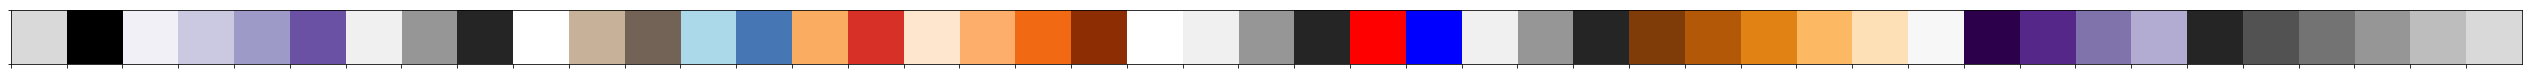

In [94]:
# choose color from here
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

df_clrs = pd.read_csv(colormap_f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]
sns.palplot(df_clrs[1][:])
df_clrs[0][-15:]

# 3. mutation matrix

In [21]:
df = pd.read_csv(mutation_f, index_col='percentage')
# sort gene based on frequency
df = df.sort_values('mfreq', ascending=False)
df.head(3)

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
percentage,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive
Putative_histology,100,100,102,Adeno,Adeno,Adeno,Adeno,Adenosquamous,Adenosquamous,Neuroendocrine,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
PIK3CA(35%),28,44,35,Non-synonymous,NaN,NaN,NaN,Non-synonymous,NaN,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


no SMGs significantly enriched in HIV+ or HIV- patients

In [22]:
pos_s = df[[i for i in df.columns if (i.startswith('HTMCP') and df.loc['HIV_status',i]=='Positive')]].notna().sum(axis=1)
neg_s = df[[i for i in df.columns if (i.startswith('HTMCP') and df.loc['HIV_status',i]=='Negative')]].notna().sum(axis=1)
mut_counts = pd.DataFrame([pos_s, neg_s]).T
mut_counts.columns = ['pos', 'neg']
mut_counts
npos = 73
nneg = 45
calculate_fisher_pvalue(mut_counts)
mut_counts

,pos,neg
percentage,,
HIV_status,73,45
Putative_histology,73,45
PIK3CA(35%),21,20
FAT1(19%),12,10
MLL2(15%),7,10
FBXW7(10%),6,6
CASP8(7%),5,3
SLC35G5(7%),7,1
MAPK1(5%),4,2


,pos,neg,fisher_pvalue
percentage,,,
HIV_status,73,45,1.000000
Putative_histology,73,45,1.000000
PIK3CA(35%),21,20,0.111175
FAT1(19%),12,10,0.471432
MLL2(15%),7,10,0.065438
FBXW7(10%),6,6,0.531927
CASP8(7%),5,3,1.000000
SLC35G5(7%),7,1,0.152690
MAPK1(5%),4,2,1.000000


In [23]:
# sort patients based on if a gene is mutated or not in the order of genes
dfx = df[[i for i in tqdm(df.columns) if i.startswith('HTMCP')]]
dfy = dfx.drop(['HIV_status','Putative_histology' ])
dfq = dfx.loc[['HIV_status','Putative_histology'],]
dfz = dfy.notnull()
dfz

100%|██████████| 121/121 [00:00<00:00, 223868.89it/s]


,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,HTMCP-03-06-02214,HTMCP-03-06-02063,HTMCP-03-06-02042,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(35%),True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FAT1(19%),False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
MLL2(15%),False,False,True,False,False,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FBXW7(10%),False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CASP8(7%),False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SLC35G5(7%),False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MAPK1(5%),False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PCDHGA12(5%),False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PSPC1(5%),False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
dfxx = pd.concat([dfz, dfq]).drop('Putative_histology').replace('Positive', True).replace('Negative', False)
# dfxx
# sorted_pats = sort_patients(dfz)
sorted_pats = sort_patients(dfxx)

sorted_patients = ['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq',] + sorted_pats
df = df[sorted_patients]
df
# sorted_pats[:3]
# df.head(3)

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02428,HTMCP-03-06-02215,HTMCP-03-06-02036,HTMCP-03-06-02040,...,HTMCP-03-06-02057,HTMCP-03-06-02332,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02185,HTMCP-03-06-02156,HTMCP-03-06-02037,HTMCP-03-06-02008,HTMCP-03-06-02046
percentage,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Positive,Negative,Negative,Positive,Negative,Negative,Negative,...,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,100,100,102,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
PIK3CA(35%),28,44,35,Non-synonymous,Multi_hit,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1(19%),16,22,19,Non-synonymous,Multi_hit,Non-synonymous,Multi_hit,Non-synonymous,Stop gained,Synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2(15%),9,22,15,Multi_hit,Multi_hit,Stop gained,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FBXW7(10%),8,13,10,NaN,NaN,NaN,Non-synonymous,Non-synonymous,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CASP8(7%),6,6,7,Frameshift,NaN,NaN,NaN,NaN,Non-synonymous,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SLC35G5(7%),9,2,7,Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAPK1(5%),5,4,5,NaN,NaN,NaN,Non-synonymous,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5. covariates

In [25]:
df_cov = pd.read_csv(covariate_f, sep='\t', index_col='patient')
df_cov.head()

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
tumor_grade,G2,unknown,G3,G3,unknown,G2,unknown,G3,G2,G2,...,G2,unknown,G1,G3,unknown,G2,G3,unknown,G3,G3
age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65
clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
APOBEC_signature,strong,strong,weak,moderate,moderate,moderate,moderate,strong,moderate,moderate,...,strong,weak,weak,moderate,moderate,weak,weak,weak,weak,weak
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative


In [26]:
df_cov = df_cov.drop('tumor_grade')
df_cov

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65
clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
APOBEC_signature,strong,strong,weak,moderate,moderate,moderate,moderate,strong,moderate,moderate,...,strong,weak,weak,moderate,moderate,weak,weak,weak,weak,weak
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous


In [27]:
df_cov = df_cov.T.rename(columns={'Putative_histology':'Histology', 'clinical_stage': 'Clinical_stage', 'age_at_diagnosis': 'Age_at_diagnosis'}).T

In [28]:
df_cov = df_cov.loc[['HIV_status', 'Histology', 'APOBEC_signature',  'Clinical_stage', 'Age_at_diagnosis' ]]

#### HRD scores

In [29]:
hrd = pd.read_csv(hrd_f, sep='\t')
hrd = hrd[['sample_id', 'HRD']].set_index('sample_id')
bins = [-1, 10, 30, 60]
labels = ['<=10', '10-30', '>30']

hrd['HRD'] = pd.cut(hrd['HRD'], right=True, bins=bins, labels=labels)
hrd = hrd.T
hrd.head(2)

sample_id,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
HRD,<=10,<=10,>30,>30,<=10,<=10,<=10,10-30,10-30,<=10,...,10-30,10-30,10-30,10-30,<=10,10-30,10-30,<=10,>30,<=10


In [30]:
df_cov

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Histology,Squamous,Squamous,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,...,Adeno,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
APOBEC_signature,strong,strong,weak,moderate,moderate,moderate,moderate,strong,moderate,moderate,...,strong,weak,weak,moderate,moderate,weak,weak,weak,weak,weak
Clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
Age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65


In [31]:
df_cov = pd.concat([df_cov, hrd], sort=False)

# 6. get coding mutation rate per mb

In [32]:
# codingmut_rate_f  = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/coding_mutation_rate.txt'
# df_cmutrate.to_csv(of, sep='\t', index=False)
df_cmutrate = pd.read_csv(codingmut_rate_f, index_col='patient')
df_cmutrate = df_cmutrate.loc[patients,]
df_cmutrate.head(2)
df_cmutrate.shape

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,...,patient_id,pregnancies_count_induced_abortion,pregnancies_count_miscarriage,tobacco_smoking_history_indicator,total_pregnancy_count,tumor_grade,weight_kg_at_diagnosis,syno_mut_rate,nsyno_mut_rate,total
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,25732,1242,329,11,102,0,26974,340,102,238,...,2001.0,NaN,1.0,1.0,6.0,G2,44.5,3.560476,8.307778,11.868255
HTMCP-03-06-02002,15964,697,225,2,72,0,16661,227,72,155,...,2002.0,3.0,NaN,1.0,11.0,G3,70.2,2.513277,5.410528,7.923805


(118, 48)

### stage counts
hiv pos have more stage 1, 
hiv neg have more stage 2

In [33]:
df_stage1 = df_cov.T[['HIV_status', 'Clinical_stage']].reset_index()

In [34]:
df_stage1[:3]

,index,HIV_status,Clinical_stage
0,HTMCP-03-06-02260,Positive,Stage I
1,HTMCP-03-06-02428,Positive,Stage II
2,HTMCP-03-06-02139,Positive,Stage IV


In [35]:
df_stage = df_stage1.pivot_table(index='HIV_status', columns='Clinical_stage', values='index', aggfunc='count').T
df_stage.columns = ['neg', 'pos']
df_stage

,neg,pos
Clinical_stage,,
Stage I,2,16
Stage II,27,26
Stage III,13,25
Stage IV,2,4
unknown,1,2


In [36]:
calculate_fisher_pvalue(df_stage)
df_stage

,neg,pos,fisher_pvalue
Clinical_stage,,,
Stage I,2,16,0.015646
Stage II,27,26,0.013169
Stage III,13,25,0.685398
Stage IV,2,4,1.000000
unknown,1,2,1.000000


In [37]:
df = df.drop(['HIV_status', 'Putative_histology'])

# 7. copy number changes reported  by GATK CNVs

this is an important paper to reference when decide the thresholds for copy number amplification and deletion in the SMGs

https://www.pnas.org/content/suppl/2007/11/20/0710052104.DC1#F7

### cnv heatmap based on gistic all_gene_threshold file

reference paper: https://www.sciencedirect.com/science/article/pii/S1535610819300960#fig1

definition of gain, amplification, loss, and deletion:

(C) Known cancer-related genes located in significant GISTIC peaks with residual q < 1 × 10−4 (amplification, gain, neutral, loss, and deletion were defined as GISTIC +2, +1, 0, −1, and −2, respectively).

(A–C) Asterisks indicate associations with mRNA subtypes (intrinsic subtype, ASCAT ploidy, lymph node status, and somatic copy-number alterations were tested using Pearson's chi-square test; ASCAT purity and homologous recombination deficiency [HRD] score were tested using the Kruskal-Wallis test; age at surgery was tested using analysis of variance; apocrine differentiation and somatic mutations were tested using Fisher's exact test. ∗∗p < 0.01, ∗p < 0.05).

To assess somatic copy number alterations (CNAs), reported oncogenes and tumor suppressor genes observed in the top rank (residual q < 1 × 10−4) GISTIC peaks were examined 

 GISTIC2.0 was run with the following parameters changed from the default settings (-ta 0.2 -td 0.2 -genegistic 1 -smallmem 1 -broad 1 -conf 0.95 -rx 0 –brlen 0.7 -cap 3.5 –armpeel 1).
 
#### all_thresholded.by_genes.txt
The table in this file is obtained by applying both low- and high-level thresholds to the gene copy levels of all the samples. The entries with value +/- 2 exceed the high-level thresholds for amps/dels, and those with +/- 1 exceed the low-level thresholds but not the high-level thresholds. The low-level thresholds are just the 'amplifications_threshold' and 'deletions_threshold' noise threshold input values (typically 0.1 or 0.3) and are the same for every threshold.
By contrast, the high-level amplification (or deletion) thresholds are calculated on a sample-by-sample basis and are based on the maximum (or minimum) median arm-level amplification (or deletion) copy number found in the sample. The idea, for deletions anyway, is that this level is a good approximation for hemizygous given the purity and ploidy of the sample. The actual cutoffs used for each sample can be found in a table in the sample_cutoffs.txt file.
 
 

In [38]:
# get ordered smgs and patient
smgs = df.index.tolist()
smgs = [i.split('(')[0] for i in smgs]
smgs[:2]
patients = df.columns.tolist()[3:]
patients[:2]

['PIK3CA', 'FAT1']

['HTMCP-03-06-02260', 'HTMCP-03-06-02214']

In [39]:
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/all_thresholded.by_genes.txt'
dfcnv = pd.read_csv(f, sep='\t')
dfcnv.drop(['Locus ID', 'Cytoband'], axis=1, inplace=True)
dfcnv = dfcnv[dfcnv['Gene Symbol'].isin(smgs)].set_index('Gene Symbol')
dfcnv = dfcnv.loc[smgs, :]
dfcnv.head()

# why these 2 patient are missing gistic thresholded cnvs
# excluded in the run because of high segment count as indicated in sample_seg_counts.txt file.
# because the marksfile is different for 2 runs, more markers in 118 patients, which resulted in higher segment count
# by looking into hiv+ and - runs, only 02344 has pik3ca amplification, no amp or del involving these two samples
dfcnv.loc[:,'HTMCP-03-06-02210' ] = 0
dfcnv.loc[:, 'HTMCP-03-06-02344' ] = 0
dfcnv.loc['PIK3CA', 'HTMCP-03-06-02344'] = 2

ordered_pats = [p for p in df.columns if p.startswith('HTMCP')]
ordered_pats[:2]

df.shape
dfcnv.shape
len(ordered_pats)

dfcnv = dfcnv[ordered_pats]

,HTMCP-03-06-02256,HTMCP-03-06-02332,HTMCP-03-06-02414,HTMCP-03-06-02435,HTMCP-03-06-02261,HTMCP-03-06-02175,HTMCP-03-06-02098,HTMCP-03-06-02216,HTMCP-03-06-02155,HTMCP-03-06-02057,...,HTMCP-03-06-02176,HTMCP-03-06-02174,HTMCP-03-06-02239,HTMCP-03-06-02354,HTMCP-03-06-02259,HTMCP-03-06-02180,HTMCP-03-06-02344,HTMCP-03-06-02213,HTMCP-03-06-02179,HTMCP-03-06-02001
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
PIK3CA,1,1,0,1,1,1,0,0,0,1,...,1,1,1,1,0,1,2,1,1,2
FAT1,0,0,-1,-1,1,-1,-1,-1,0,0,...,-1,0,-1,-1,-1,-1,-1,-1,-1,0
MLL2,0,0,-1,-1,1,1,0,-1,0,0,...,0,0,0,0,1,0,1,0,0,0
FBXW7,0,0,-1,-1,0,-1,-1,-1,0,0,...,0,0,-1,-1,-1,-1,-1,1,-1,0
CASP8,0,0,1,0,1,0,0,0,0,0,...,-1,1,1,-1,1,0,0,-1,0,-1


['HTMCP-03-06-02260', 'HTMCP-03-06-02214']

(12, 121)

(12, 118)

118

In [40]:
# cnvs = pd.read_csv(gatk_cnv, sep='\t', index_col='Gene Symbol')

In [41]:
# why these 2 patient has no copy results?
# not clear. confirmed both patients are in the segmentation file, but not in all_data_by_gene file
# both numbers make sense in hiv_pos and hiv_neg run, why not in 118_patient run
# s = cnvs.isna().any()
# s[s==True]

In [42]:
cnvs = dfcnv.loc[smgs, patients]
cnvs.fillna(0, inplace=True)
# cnvs.head(2)
# pd.Series(cnvs.values.ravel()).unique()

In [43]:
cnvs.head(2)

,HTMCP-03-06-02260,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02428,HTMCP-03-06-02215,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,...,HTMCP-03-06-02057,HTMCP-03-06-02332,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02185,HTMCP-03-06-02156,HTMCP-03-06-02037,HTMCP-03-06-02008,HTMCP-03-06-02046
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
PIK3CA,2,1,1,1,1,1,1,1,2,1,...,1,1,1,1,1,1,0,2,0,1
FAT1,0,1,-1,0,-2,-1,1,-1,0,0,...,0,0,1,0,0,-1,-1,0,0,0


In [44]:
cnvs_thresholded = cnvs[(cnvs==amp_threshold)|(cnvs==del_threshold)]

cnvs_thresholded = cnvs_thresholded.reset_index(drop=True)

cnvs_thresholded.columns = [i for i in range(cnvs_thresholded.shape[1])]
cnvs_thresholded

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1,NaN,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,-2.0,-2.0,NaN,NaN,NaN,-2.0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# for the right hbar plot cnv counts in hiv+ and - patient
dfcnvtmp = (dfcnv >=2)|(dfcnv <=-2)
dfcnvtmp2 = pd.concat([dfcnvtmp, df_cov.loc[['HIV_status'],:]], sort=False).T 
dfcnvtmp2.head(2)

,PIK3CA,FAT1,MLL2,FBXW7,CASP8,SLC35G5,MAPK1,PCDHGA12,PSPC1,ZNF750,PCDHA9,ZC3H6,HIV_status
HTMCP-03-06-02260,True,False,False,False,False,False,False,False,False,False,False,False,Positive
HTMCP-03-06-02214,False,False,False,False,False,False,False,False,False,False,False,False,Negative


In [64]:
def make_cmap_for_heatmap(categories, color_dict):
    '''map category types to a number and make a cmap for heatmap'''
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[m] for m in categories]
    cmap = colors.ListedColormap(clrs)
#     print('colors used:')
#     for cat, c in zip(categories, clrs):
#         print(cat, c)
#     sns.palplot(clrs)
    return (map_dict, cmap)

In [66]:
Patch?

In [128]:
def legend_lines(clr, lb):
    return Line2D([0], [0], color=clr, lw=2, label=lb)

def make_patch(fc, ec, lb):
    return Patch(facecolor=fc, edgecolor=ec, label=lb, linewidth=2)

def remove_axes(ax):
    _ = plt.setp(ax.get_yticklines(), visible=False)
    _ = plt.setp(ax.get_xticklines(), visible=False)
    _ = ax.set_xticklabels('')

def add_legend(ax, legend_handles, title):
    _ = remove_axes(ax)
    _ = ax.set_yticklabels('')
    leg = ax.legend(handles=legend_handles, loc='upper left', fontsize=20,  
                    bbox_to_anchor=(0.02, 0.95), title=title, frameon=False,
                    handlelength=1, handleheight=1.125)
    leg.get_title().set_fontsize(18)
    leg.set_title(leg.get_title().get_text(), prop = {'size':18, 'weight':'bold'})
    leg._legend_box.align = "center"

In [101]:
# color_dict

In [119]:
all_patches = [make_patch(v, 'white', k) for k, v in leg_colors.items()]
# all_lines = [legend_lines(v, k) for k, v in clr_dict.items()]
white_patch = make_patch('white', 'gray', 'unknown' )
hiv_patches = all_patches[:2]
histology_patches = all_patches[2:6]
age_patches = all_patches[6:9] +  [white_patch]
mut_patches = all_patches[10:16]
stage_patches = all_patches[16:20] + [white_patch]
apobec_patches = all_patches[20:23]
cn_circles = all_patches[23:25]
hrd_patches = all_patches[25:28]

# lines = all_lines[11:]
leg_patches = [hiv_patches, histology_patches, age_patches, mut_patches,
              stage_patches, apobec_patches, hrd_patches, cn_circles]

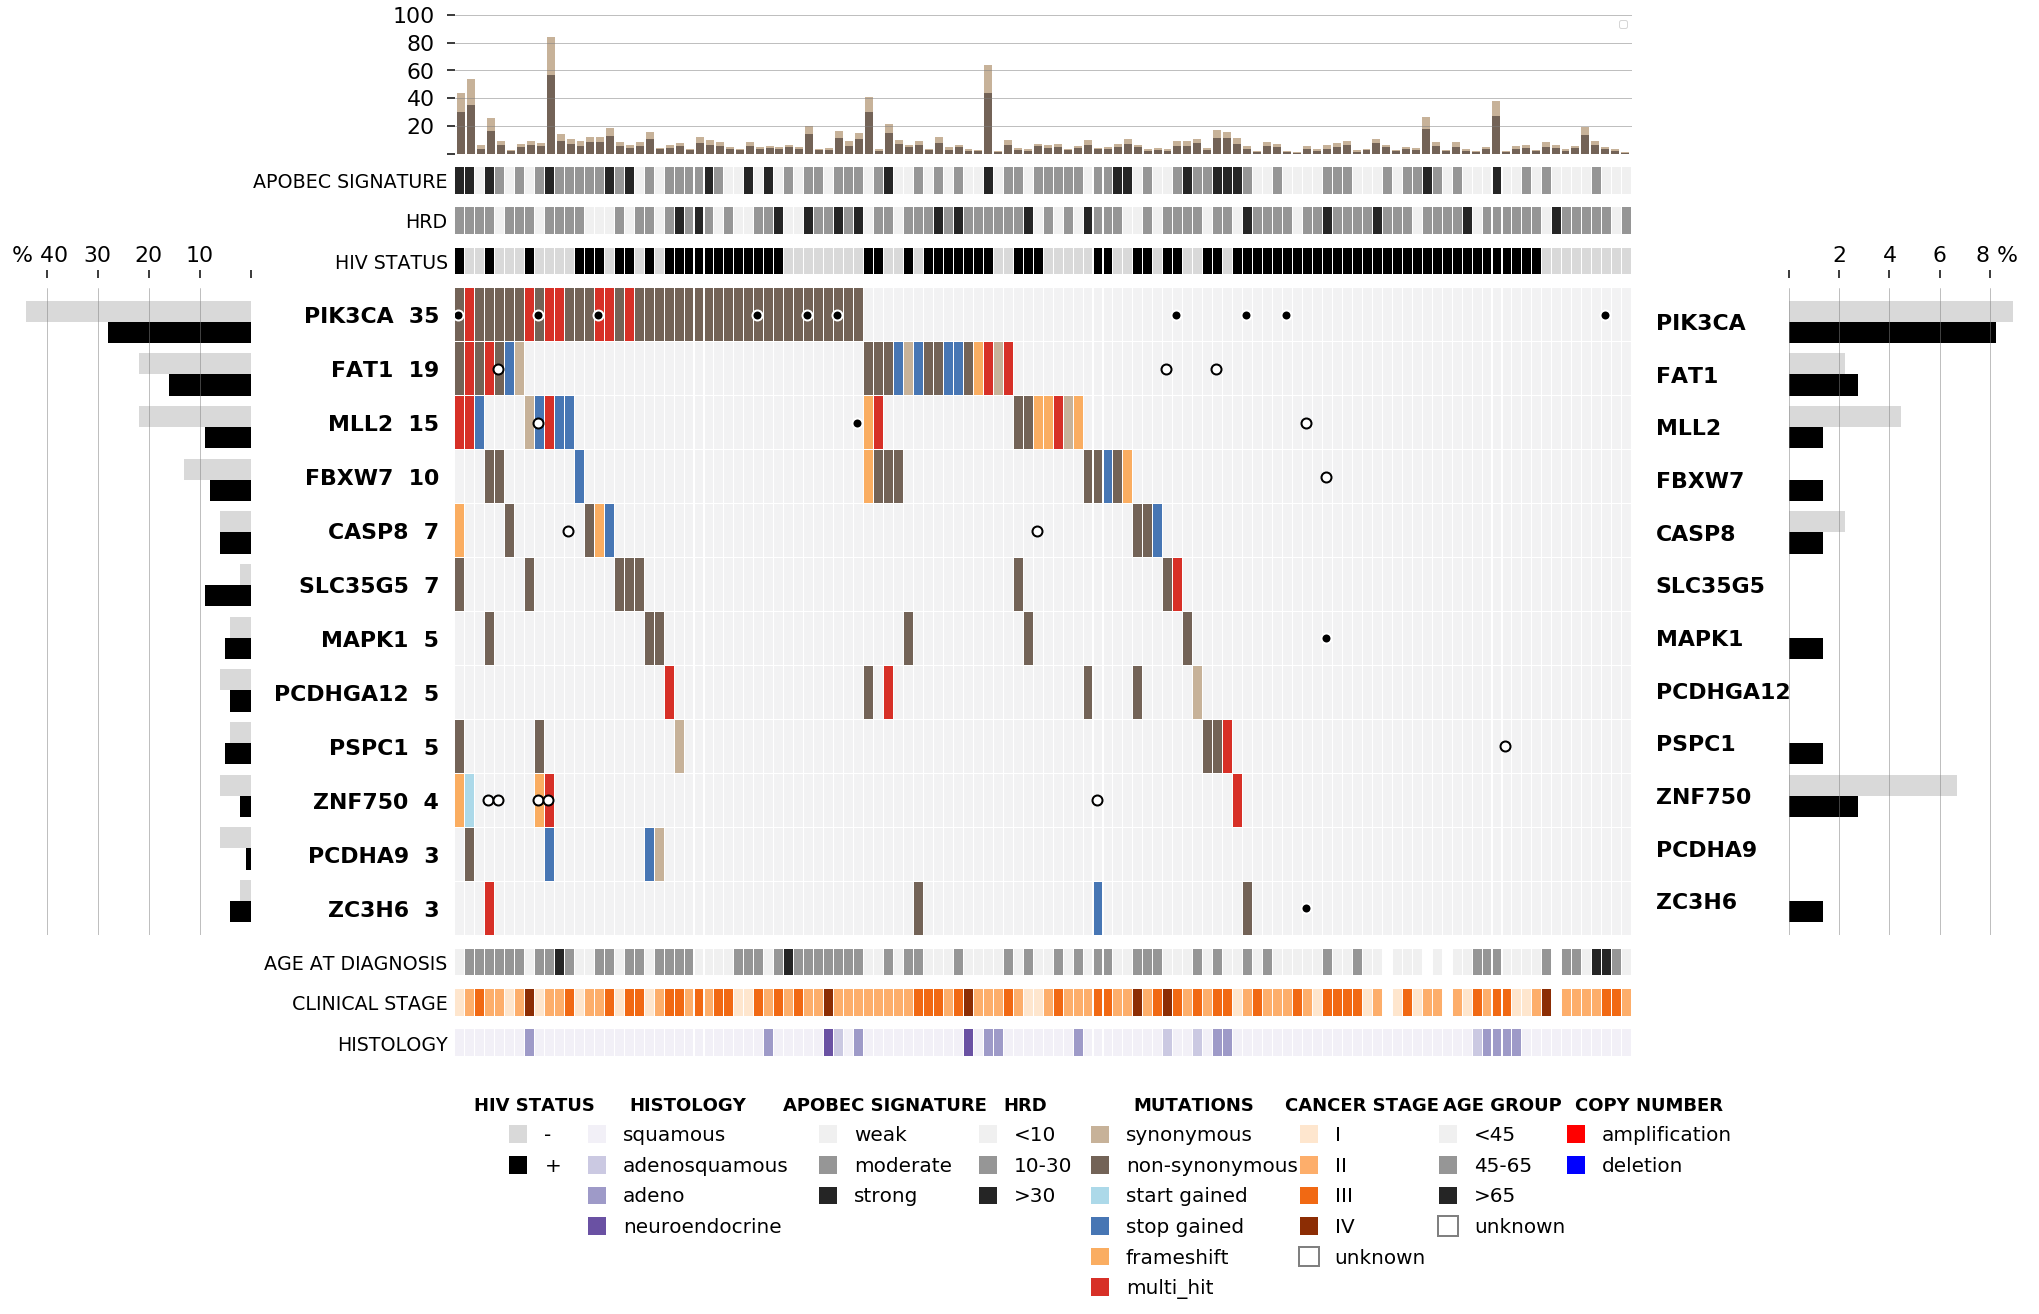

In [213]:
# df: mutation matrix
# patients: ordered columns
    
nrows = df.shape[0]    
fig = plt.figure(figsize=(36,.95*nrows*2), facecolor='white')


gs = gridspec.GridSpec(9, 5,                            
                       width_ratios=[3,2.6,15,2,3], 
                       height_ratios=[3,0.6,0.6,0.6,14,0.6,0.6, 0.6,4],
                       wspace=0, # horizontal space
                       hspace=0.1  # vertical space
                      )

patients = [p for p in df.columns.tolist() if p.startswith('HTMCP')]
# dfa plot the heatmap of different types of mutations
histology = ['Adeno', 'Squamous', 'Neuroendocrine', 'Adenosquamous']
HIV_status = ['Negative', 'Positive']
mutations = ['Non-synonymous', 
#              'Codon indel', 
             'Frameshift',              
#              'Splice site', 
             'Stop gained',
             'Start gained',
             'Synonymous',
             'Multi_hit']
# tumor_grades = ['G1', 'G2', 'G3','unknown']
stages = ['Stage I',  'Stage II', 'Stage III', 'Stage IV', 'unknown']
ages = ['<45', '45-65', '>65', 'unknown']
hrds = ['<=10', '10-30', '>30']
apobec = ['strong', 'weak', 'moderate']
copy_numbers = ['amplification', 'deletion']
# covariates2 = histology  + ages[:-1] + stages
# covariates2 = histology  + ages + stages
# covariates1 = HIV_status + apobec + hrds 
# print(covariates2)
# print(covariates1)

b_lst = ['mfreq', 'hiv_pos_mfreq', 'hiv_neg_mfreq']
d_lst = ['tumor_grade']
e_lst = ['age_at_diagnosis']
g_lst = ['clinical_stage']
dfa = df.drop(b_lst, axis=1)

# dfb for unstacked barplot of mutation rate in hiv+ and - and full cohort
dfb = df[b_lst].astype(float)

# # plot coding mutation per mb mutation rate 
gs2 = gs[2]
ax2 = plt.subplot(gs2, facecolor='white', frameon=False)
df_mutrate = plot_mutation_rate(ax2, df_cmutrate, patients, color_dict)


# add in molecular covariate track
map_dict_cov, cmap_cov = make_cmap_for_heatmap(apobec, color_dict)
# df_cov1 = df_cov.loc[['APOBEC_signature', 'HRD'],:]
# ax7 = plt.subplot(gs[7], facecolor='white')
# df_covmolecular = plot_covariate_track(ax7, df_cov1, patients, map_dict_cov, cmap_cov)

df_apobec = df_cov.loc[['APOBEC_signature'],:]
ax7 = plt.subplot(gs[7], facecolor='white')
df_apobecrt = plot_covariate_track(ax7, df_apobec, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(hrds, color_dict)
df_hrd = df_cov.loc[['HRD'],:]
ax12 = plt.subplot(gs[12], facecolor='white')
df_hrdrt = plot_covariate_track(ax12, df_hrd, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(HIV_status, color_dict)
df_hiv = df_cov.loc[['HIV_status'],:]
# print(df_hiv)
ax17 = plt.subplot(gs[17], facecolor='white')
df_hivrt = plot_covariate_track(ax17, df_hiv, patients, map_dict_cov, cmap_cov)

# plot cn alteration percentage per gene
ax24 = plt.subplot(gs[24], facecolor='white', frameon=True)
plot_cnv_rate_group(ax24, dfcnvtmp2, HIV_status, color_dict)

# plot mutation rate in hiv+ and - group, grouped barplot
ax20 = plt.subplot(gs[20], facecolor='white')
plot_gene_mutation_rate_group(ax20, dfb, HIV_status, color_dict)

# plot heatmap for gene mutations
# make map dictionary to map types to a number so that heatmap can plot
map_dict, cmap = make_cmap_for_heatmap(mutations, color_dict)
ax22 = plt.subplot(gs[22], facecolor='beige')
df_mutheatmap = plot_mutation_heatmap(ax22, dfa, map_dict, cmap)

# add in copy number changes to mutation heatmap
cnvs_thresholded1 = cnvs[(cnvs==amp_threshold)|(cnvs==del_threshold)]
cnvs_thresholded = cnvs_thresholded1.reset_index(drop=True)
cnvs_thresholded.columns = [i for i in range(cnvs_thresholded.shape[1])]
plot_copy_number(cnvs_thresholded, amp_threshold, del_threshold, ax22)


# # add in clinical covariate track
# map_dict_cov, cmap_cov = make_cmap_for_heatmap(covariates2, color_dict)
# df_cov2 = df_cov.loc[['HIV_status', 'Age_at_diagnosis', 'Clinical_stage', 'Histology'],:]
# ax17 = plt.subplot(gs[17], facecolor='white')
# df_covheatmap = plot_covariate_track(ax17, df_cov2, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(ages, color_dict)
df_age = df_cov.loc[['Age_at_diagnosis'],:]
ax27 = plt.subplot(gs[27], facecolor='white')
df_agert = plot_covariate_track(ax27, df_age, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(stages, color_dict)
df_stage = df_cov.loc[['Clinical_stage'],:]
ax32 = plt.subplot(gs[32], facecolor='white')
df_stagert = plot_covariate_track(ax32, df_stage, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(histology, color_dict)
df_histo = df_cov.loc[['Histology'],:]
ax37 = plt.subplot(gs[37], facecolor='white')
df_histort = plot_covariate_track(ax37, df_histo, patients, map_dict_cov, cmap_cov)


# gs14 = gs[14]
# ax14 = plt.subplot(gs14, facecolor='white')
# make a subplot of ax14 to control the width of the colorbar
# innergs = gridspec.GridSpecFromSubplotSpec(1, 6,
#                     subplot_spec=ax14, wspace=0.1, hspace=0.1)
# ax14_1 = plt.subplot(innergs[0], facecolor='white')


#plot numeric covariates
# add color bar for numeric covariate in a separate ax
# gs17 = gs[17]
# ax17 = plt.subplot(gs17, facecolor='white')
# num_bar = numeric_covariate(ax17, hrd, patients, ax14_1)
# plt.gcf().axes get all plotted axes in order
# colorbar axes is the 6th ax
# cax = plt.gcf().axes[-2]
# cax.tick_params(labelsize=19)

# plot all legend
gs42 = gs[42]
ax42 =  plt.subplot(gs42, frameon=False)
# add subplots in an ax made by plt.subplots to accommodate legend panels
axxs = gridspec.GridSpecFromSubplotSpec(1,8 , subplot_spec=ax42, 
                                        width_ratios=[1,2,2,1,2,1.5,1.2,1], hspace=1)
leg_titles = ['HIV STATUS', 'HISTOLOGY', 'APOBEC SIGNATURE', 'HRD',
             'MUTATIONS', 'CANCER STAGE', 'AGE GROUP', 'COPY NUMBER']
leg_patches = [hiv_patches, histology_patches, apobec_patches, hrd_patches,
               mut_patches, stage_patches, age_patches, cn_circles]
for i, (ltitle, lpatches) in enumerate(zip(leg_titles, leg_patches)):
    axx = plt.subplot(axxs[i], frame_on=False)
    add_legend(axx, lpatches, ltitle)



# a few checks to make sure patient order is consistent
# coding mutation rate  and mutation heatmap
assert (df_mutrate.index == df_mutheatmap.columns).all()
# mutation heatmap and covariate track
assert (df_mutheatmap.columns == df_covheatmap.columns).all()
# mutation heatmap and molecular covariate track
assert (df_mutheatmap.columns == df_covheatmap.columns).all()
# mutation heatmap and copy number overlay
assert (df_mutheatmap.columns == cnvs_thresholded1.columns).all()
# gene order consistent 
# mutation heatmap and copy number overlay
# [i.split() for i in df_mutheatmap.index]
# assert (dfa.index ==  dfb.index).all()
# assert (dfa.index == df_type_count_per_gene.index ).all
# color scheme consistent between type count plot and heatmap and mutation rate plot
# print('map_dict is: {}'.format(map_dict))
# print('colors are: {}'.format(clrs))
# sns.palplot(clrs)

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/smgs_cnvs_oncoprint_20190325.png'
pdf = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/smgs_cnvs_oncoprint_20190325.pdf'
# %time plt.savefig(of, bbox_inches='tight',dpi=200)
# plt.savefig(pdf,bbox_inches='tight',dpi=300)
plt.show()

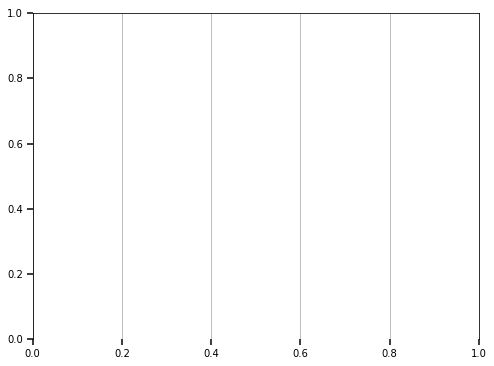

In [72]:
fig, ax = plt.subplots()
ax.tick_params(direction='out', length=6, width=1.5, colors='black', grid_linewidth=5)
ax.spines['bottom'].set_visible(False)
plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
ax.legend?

In [211]:
print(matplotlib.matplotlib_fname())

/projects/da_workspace/software/miniconda/envs/dlpy3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


### No SMGs is unique to this Uganda cohort. They are all present in TCGA at various frequency.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import  statsmodels.stats.multitest as multitest
import itertools

# plotly.offline.init_notebook_mode(connected=True)
# Standard plotly imports
import plotly.plotly as py
import pandas as pd
# import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

from plotly import tools
# cufflinks binds plotly directly to python dataframe
import cufflinks as cf
cf.go_offline()
# # Set the global theme
cf.set_config_file(world_readable=True, theme='pearl', offline=True)
# plotly.offline.init_notebook_mode(connected=True)


%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
df.iplot?

In [ ]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/smgs_frequency_tcga_vs_nci.csv'
df = pd.read_csv(f, sep='\t',usecols=[0,2,4], header=None)
df.columns = ['gene', 'pct_tcga', 'pct_nci']
# df = df.set_index('gene')
# sns.scatterplot('pct_nci', 'pct_tcga', data=df)

In [ ]:
# df.iplot(kind='bar')
       
trace1 = go.Bar(x=df.gene,
                y=df.pct_tcga,
                name='TCGA')
trace2 = go.Bar(x=df.gene,
                y=df.pct_nci,
                name='HTMCP')

data = [trace1, trace2]
layout = go.Layout(barmode='group',
                   width=700,
                   height=500,
                  yaxis=dict(type='-', title='mutation frequency'),
                  xaxis=dict(title=''))

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='xxx.png')
# this does not save the iamge, instead click 'save as png' on the right top corner of the plot to save

In [ ]:
ff = '/projects/trans_scratch/validations/workspace/szong/Cervical/master_patient_table_20180813_123samples_all.txt'
dff = pd.read_csv(ff, sep='\t')
dff

In [ ]:
dff2 = dff[['id', 'Clade', 'strelka_mutations']]



dff2 = dff2[dff2.id.isin(patients)]
dff2[dff2.Clade=='None']

In [ ]:
dff2.Clade.unique()

In [ ]:
dff2[dff2.Clade=='none']

In [ ]:
seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [ ]:
ax = sns.boxplot('Clade', 'strelka_mutations', data=dff2)
ax.set_yscale('log')
plt.savefig('/projects/trans_scratch/validations/workspace/szong/Cervical/mutation_load_between_clades.png', bbox_inches='tight', dpi=200)